In [33]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt
import json
import requests
import pickle
import gzip as gz

import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src/')
from CellType_PSY import *

# Structure in Common vs Corr Null Hypo

In [2]:
def FixSubiculum(DF):
    X = DF.loc["Subiculum_dorsal_part"]
    Y = DF.loc["Subiculum_ventral_part"]
    Z = [(X[0]+Y[0])/2, "Hippocampus", 214]
    DF.loc["Subiculum"] = Z
    DF = DF.drop(["Subiculum_dorsal_part", "Subiculum_ventral_part"])
    return DF

In [3]:
ASD_STR_Bias = pd.read_csv("../../ASD_Circuits/dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.csv", index_col=0)
ASD_STR_Bias = FixSubiculum(ASD_STR_Bias)
#SC_Agg_Bias = pd.read_csv("dat/Bias/ASD.MERFISH.Agg.adj.bias.csv", index_col=0)
SC_Agg_Bias = pd.read_csv("dat/Bias/ASD.MERFISH.AggV2.adj.bias.csv", index_col=0)

In [5]:
ASD_CircuitsSet = pd.read_csv(
    "/home/jw3514/Work/ASD_Circuits/notebooks/ASD.SA.Circuits.Size46.csv",
    index_col="idx")
ASD_Circuits = ASD_CircuitsSet.loc[3, "STRs"].split(";")
ASD_Circuits.append("Subiculum")

In [6]:
for i,row in ASD_STR_Bias.iterrows():
    ASD_STR_Bias.loc[i, "SC_Bias"] = SC_Agg_Bias.loc[i, "EFFECT"]
    ASD_STR_Bias.loc[i, "SC_Rank"] = int(SC_Agg_Bias.loc[i, "Rank"])
    if i in ASD_Circuits:
        ASD_STR_Bias.loc[i, "isCir"] = 1
    else:
        ASD_STR_Bias.loc[i, "isCir"] = 0

In [7]:
R,P = pearsonr(ASD_STR_Bias["EFFECT"].values, ASD_STR_Bias["SC_Bias"].values)
print(R, P)

0.7327720211672722 5.808279489297639e-37


In [59]:
STR_Com = len(set(ASD_STR_Bias.head(50).index.values).intersection(set(SC_Agg_Bias.head(50).index.values)))
STR_Com

27

In [8]:
CompareList(SC_Agg_Bias.head(50).index.values, ASD_Circuits)

Common: 24 {'Anteromedial_visual_area', 'Primary_somatosensory_area_lower_limb', 'Dentate_gyrus', 'Orbital_area_medial_part', 'Agranular_insular_area_ventral_part', 'Lateral_visual_area', 'Primary_motor_area', 'Posterior_parietal_association_areas', 'Claustrum', 'Secondary_motor_area', 'Basomedial_amygdalar_nucleus', 'Nucleus_accumbens', 'Orbital_area_lateral_part', 'Orbital_area_ventrolateral_part', 'Prelimbic_area', 'Caudoputamen', 'Retrosplenial_area_lateral_agranular_part', 'Primary_visual_area', 'Anterior_cingulate_area_dorsal_part', 'Gustatory_areas', 'Anterior_olfactory_nucleus', 'Anterior_cingulate_area_ventral_part', 'Infralimbic_area', 'Primary_somatosensory_area_trunk'}
Present in 1: 26 {'Primary_somatosensory_area_upper_limb', 'Supplemental_somatosensory_area', 'Presubiculum', 'Primary_somatosensory_area_nose', 'Posterolateral_visual_area', 'Agranular_insular_area_dorsal_part', 'Olfactory_tubercle', 'Visceral_area', 'Medial_amygdalar_nucleus', 'Anterolateral_visual_area', '

In [52]:
tmp_ASD_STR_Bias = ASD_STR_Bias.copy(deep=True)

In [68]:
variances = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3]
Corr_dat_at_var = []
STR_in_Comm_at_var = []
for variance in variances:
    for i in range(50):
        noise = np.random.normal(0, np.sqrt(variance), tmp_ASD_STR_Bias['EFFECT'].shape)
        tmp_ASD_STR_Bias["EFFECT2"] = tmp_ASD_STR_Bias["EFFECT"] + noise
        R, p = pearsonr(ASD_STR_Bias["EFFECT"].values, tmp_ASD_STR_Bias["EFFECT"].values)
        tmp_ASD_STR_Bias = tmp_ASD_STR_Bias.sort_values("EFFECT2", ascending=False)
        STR_Com = len(set(ASD_STR_Bias.head(50).index.values).intersection(set(tmp_ASD_STR_Bias.head(50).index.values)))
        Corr_dat_at_var.append(R)
        STR_in_Comm_at_var.append(STR_Com)
Corr_dat_at_var = np.array(Corr_dat_at_var)
STR_in_Comm_at_var = np.array(STR_in_Comm_at_var)

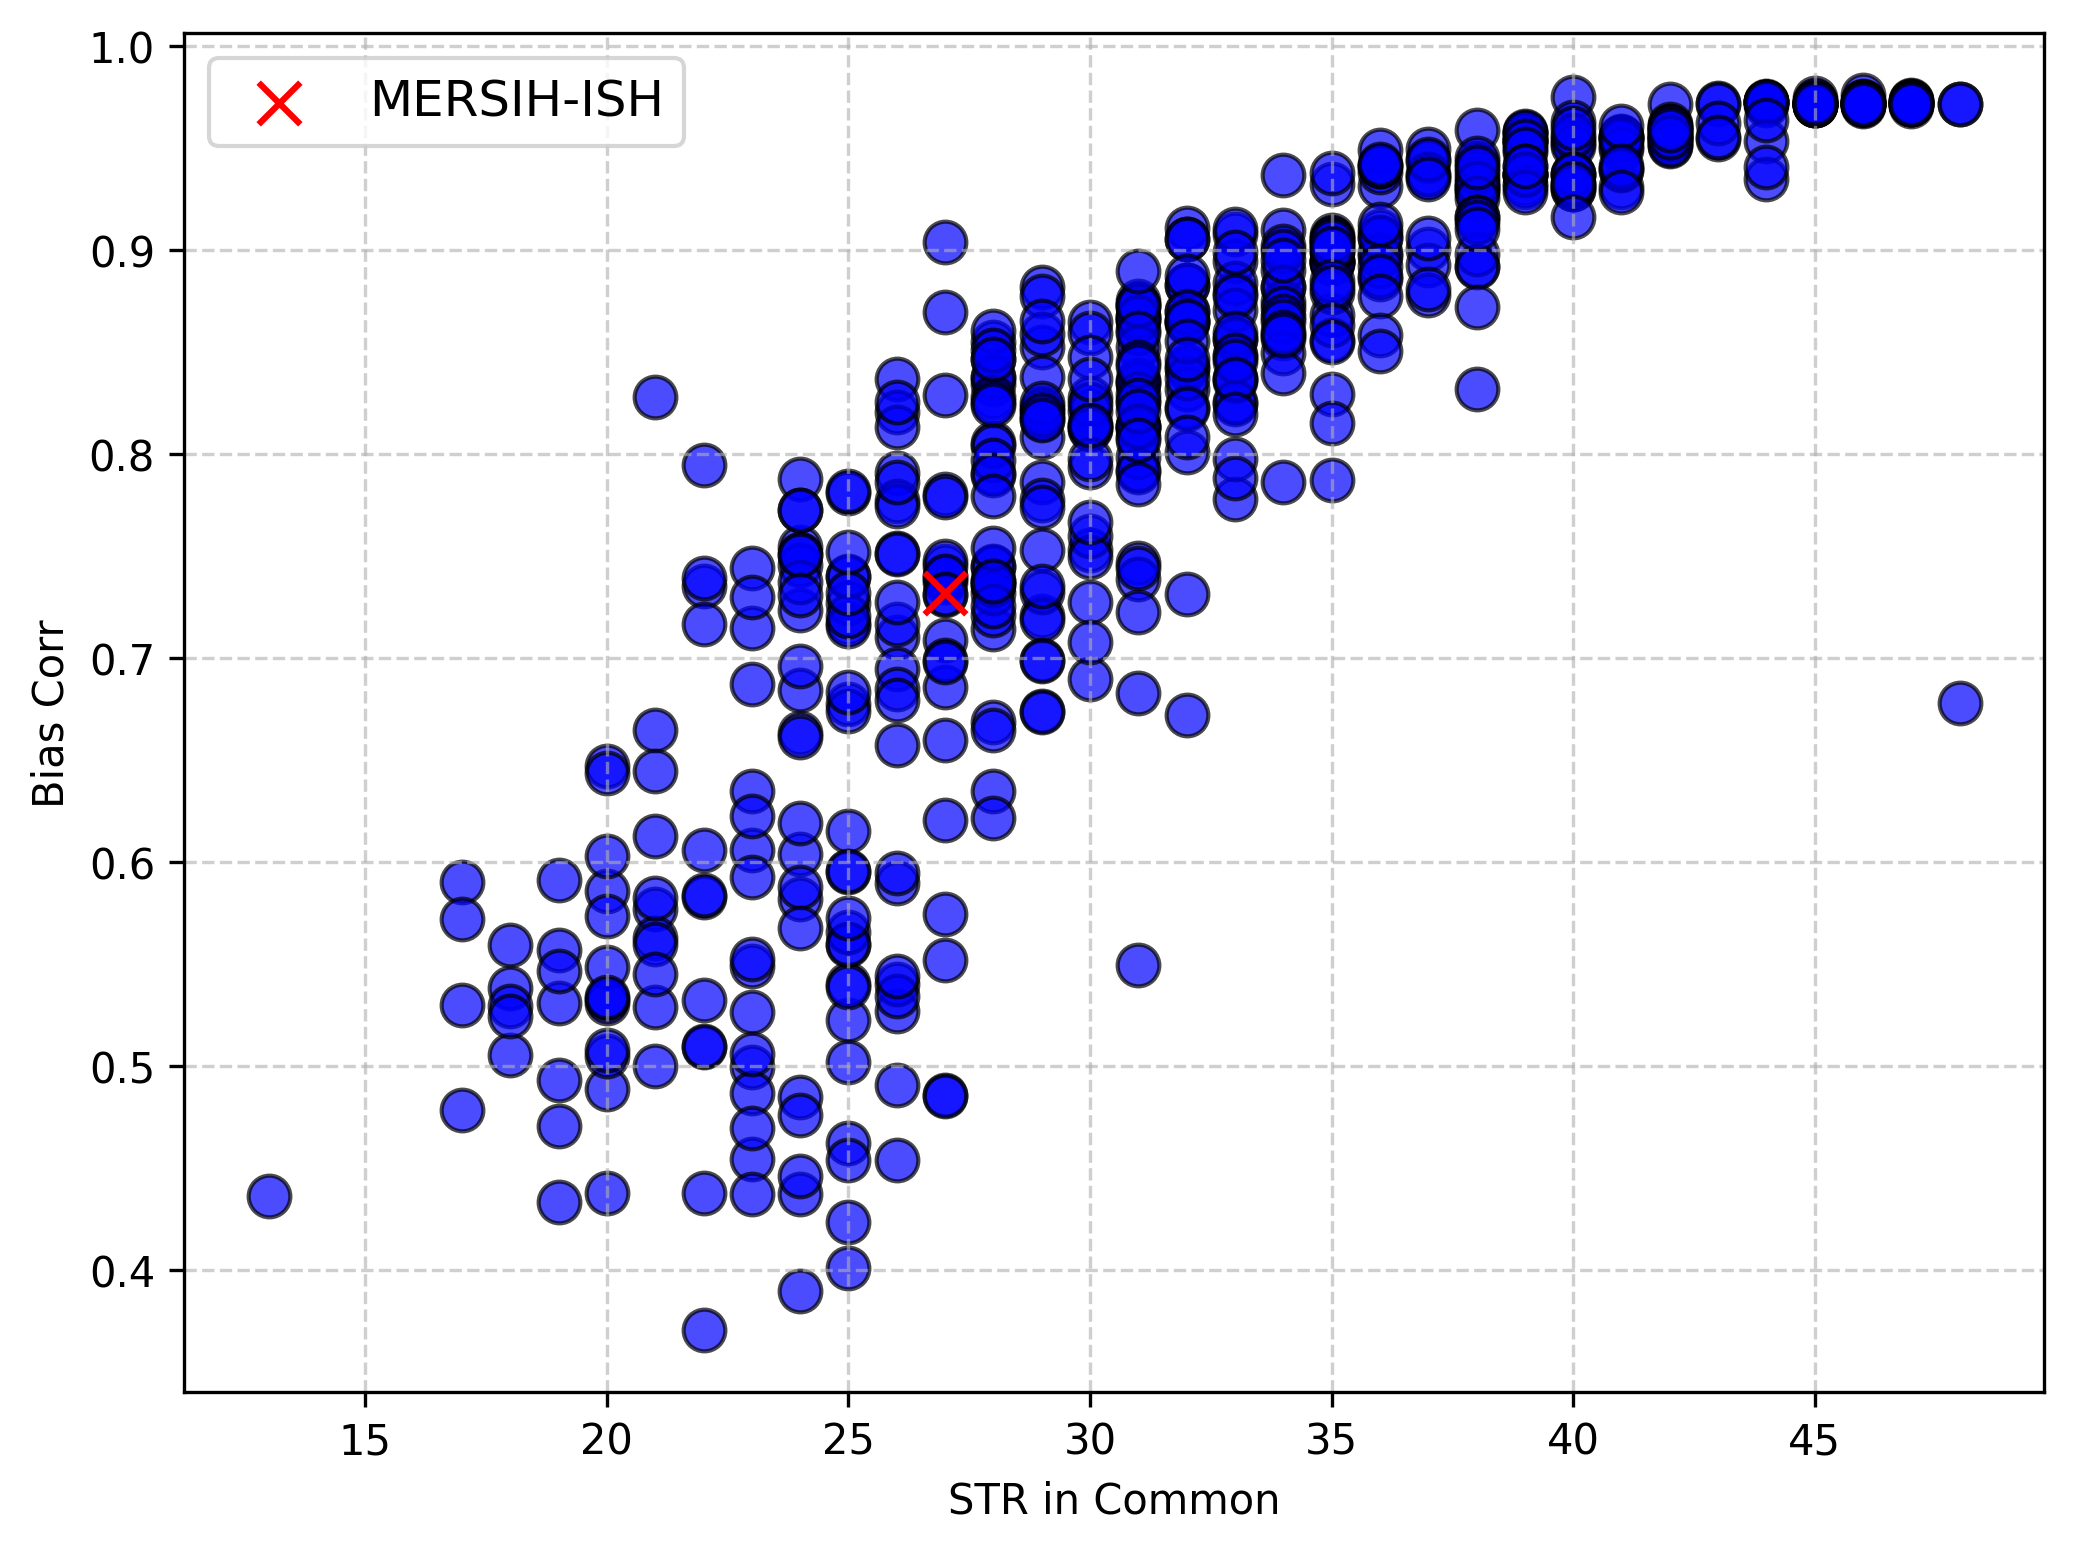

In [69]:
plt.figure(dpi=300, figsize=(8, 6))
plt.scatter(STR_in_Comm_at_var, Corr_dat_at_var, color='blue', s=100, alpha=0.7, edgecolor='k')
plt.scatter(27, 0.732, color="red", s=100, label='MERSIH-ISH', marker="x")

plt.xlabel("STR in Common")
plt.ylabel("Bias Corr")
plt.legend(fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Try other things that might help

In [143]:
MERFISH_Z2_Cell = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_CellMean.Z2.csv",index_col=0)
MERFISH_Z2_Vol = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_VolMean.Z2.csv", index_col=0)
MERFISH_Z2_Cell2 = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_CellMean.ISH.Match.Z2.csv", index_col=0)

In [144]:
head = MERFISH_Z2_Cell.columns.values
new_head = [X.replace(" ", "_") for X in head]

MERFISH_Z2_Cell.columns = new_head
MERFISH_Z2_Vol.columns = new_head
MERFISH_Z2_Cell2.columns = new_head

In [145]:
ASD_GW = Fil2Dict("../../ASD_Circuits/dat/Unionize_bias/Spark_Meta_EWS.GeneWeight.csv")
#del ASD_GW[23126]

In [146]:
ISH_SC_CorrDF = pd.read_csv("dat/ISH_MERFISH_Gene_CorssSTR_Corr.v2.csv", index_col=0)
ASD_GW_adj = {}
for k,v in ASD_GW.items():
    if k in ISH_SC_CorrDF.index.values:
        ASD_GW_adj[k] = v * (ISH_SC_CorrDF.loc[k, "V2_V3_CT_Corr"]**2)

In [147]:
len(ASD_GW_adj)

60

In [148]:
ASD_Bias_MERFISH_Z2_Cell = AvgSTRZ_Weighted(MERFISH_Z2_Cell, ASD_GW_adj)
ASD_Bias_MERFISH_Z2_Vol = AvgSTRZ_Weighted(MERFISH_Z2_Vol, ASD_GW_adj)
ASD_Bias_MERFISH_Z2_Cell2 = AvgSTRZ_Weighted(MERFISH_Z2_Cell2, ASD_GW_adj)

In [125]:
#ASD_Bias_MERFISH_Z2_Vol.head(50)

In [126]:
STR_Com = len(set(ASD_STR_Bias.head(50).index.values).intersection(set(ASD_Bias_MERFISH_Z2_Vol.head(50).index.values)))
STR_Com

19

In [128]:
STR_Com = len(set(ASD_STR_Bias.head(50).index.values).intersection(set(ASD_Bias_MERFISH_Z2_Cell.head(50).index.values)))
STR_Com

17

In [100]:
STR_Com = len(set(ASD_Bias_MERFISH_Z2_Cell.head(50).index.values).intersection(set(ASD_Bias_MERFISH_Z2_Vol.head(50).index.values)))
STR_Com

41

(0.5391604076991328, 2.1941522345039996e-17)


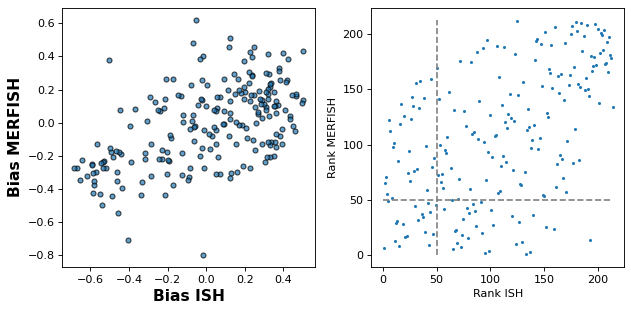

In [149]:
BiasCorrelation(ASD_STR_Bias, ASD_Bias_MERFISH_Z2_Cell, "ISH", "MERFISH")

(0.5707085800183861, 1.0204164173952548e-19)


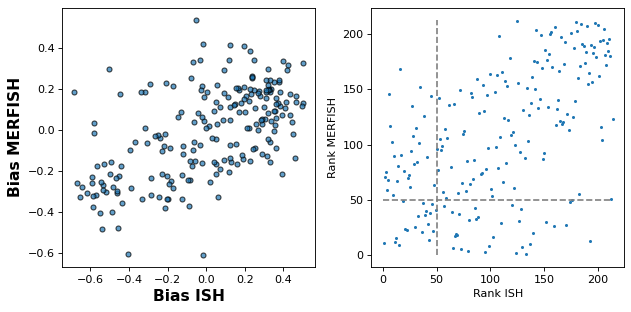

In [102]:
BiasCorrelation(ASD_STR_Bias, ASD_Bias_MERFISH_Z2_Vol, "ISH", "MERFISH")

In [132]:
MERFISH_Z2_Cell = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_CellMean.ISH.Match.Z2.csv",index_col=0)
head = MERFISH_Z2_Cell.columns.values
new_head = [X.replace(" ", "_") for X in head]
MERFISH_Z2_Cell.columns = new_head
ISH_Z2 = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/allen-mouse-exp/AllenMouseBrain_Z2bias.csv", index_col=0)

In [133]:
ASD_MERFISH = AvgSTRZ_Weighted(MERFISH_Z2_Cell, ASD_GW) 
ASD_MERFISH_adj = AvgSTRZ_Weighted(MERFISH_Z2_Cell, ASD_GW_adj) 

(0.6184918697008656, 9.12507276462255e-24)


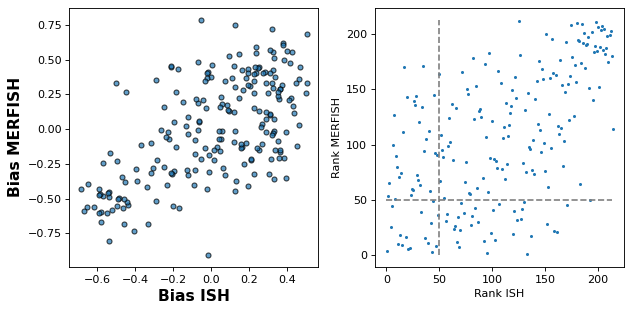

In [134]:
BiasCorrelation(ASD_STR_Bias, ASD_MERFISH_adj, "ISH", "MERFISH")

(0.6184918697008656, 9.12507276462255e-24)


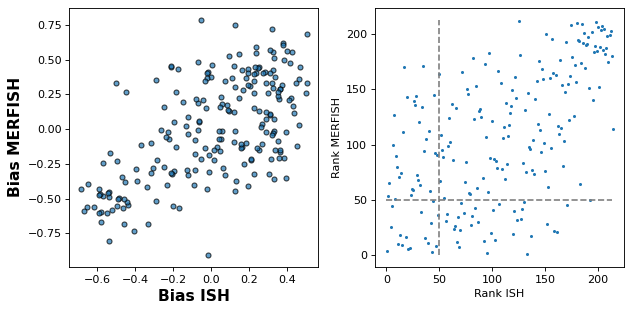

In [135]:
BiasCorrelation(ASD_STR_Bias, ASD_MERFISH_adj, "ISH", "MERFISH")

In [116]:
ASD_ISH = pd.read_csv("dat/Bias/ASD.ISH.bias.csv", index_col=0)
ASD_MERFISH_adj = pd.read_csv("dat/Bias/ASD.MERFISH.Agg.adj.bias.csv", index_col=0)

(0.6911499040534725, 1.910569802708631e-31)


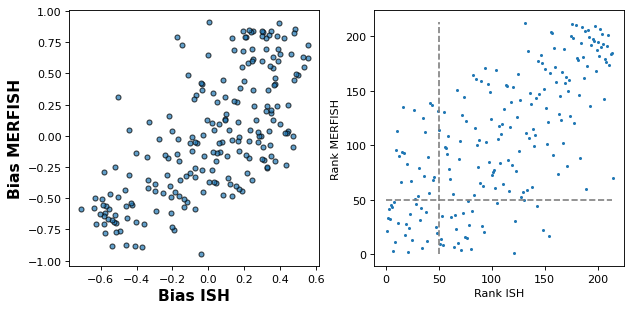

In [117]:
BiasCorrelation(ASD_ISH, ASD_MERFISH_adj, "ISH", "MERFISH")

(0.9528086635584353, 1.0861925454993154e-110)


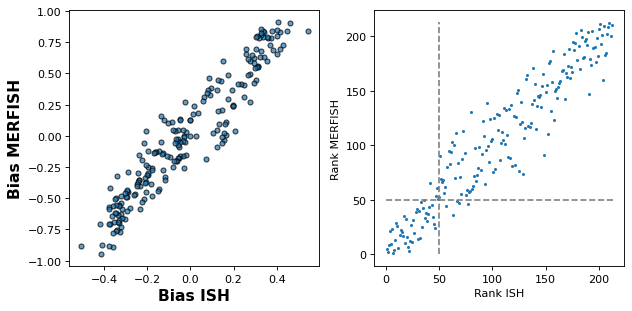

In [118]:
BiasCorrelation(SC_Agg_Bias, ASD_MERFISH_adj, "ISH", "MERFISH")

(0.7819011228417053, 5.588009562397617e-45)


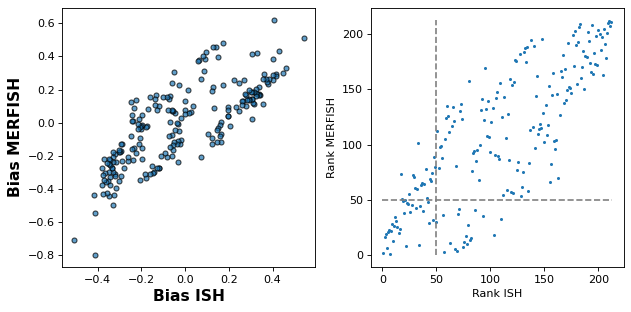

In [150]:
BiasCorrelation(SC_Agg_Bias, ASD_Bias_MERFISH_Z2_Cell, "ISH", "MERFISH")

(0.8072509673729604, 5.5377986347789e-50)


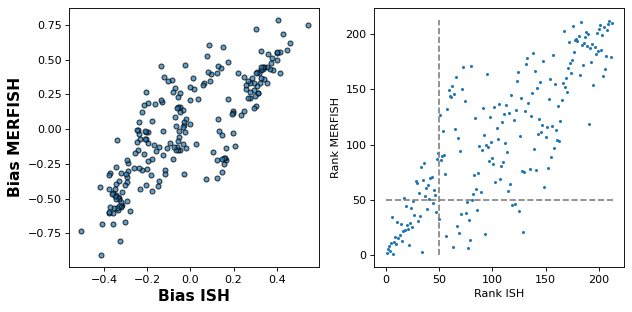

In [152]:
BiasCorrelation(SC_Agg_Bias, ASD_Bias_MERFISH_Z2_Cell2, "ISH", "MERFISH")

(0.8063943179672244, 8.402142743316845e-50)


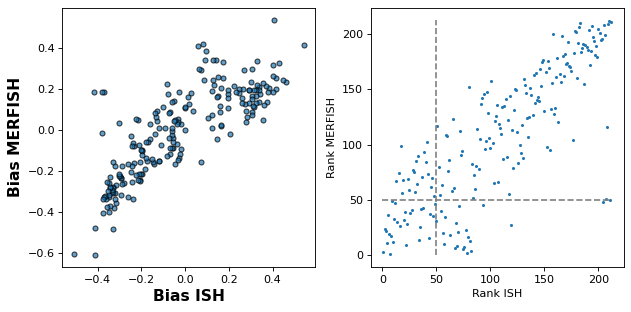

In [151]:
BiasCorrelation(SC_Agg_Bias, ASD_Bias_MERFISH_Z2_Vol, "ISH", "MERFISH")

In [119]:
Bias1 = SC_Agg_Bias
Bias2 = ASD_MERFISH_adj
STR_Com = len(set(Bias1.head(50).index.values).intersection(set(Bias2.head(50).index.values)))
STR_Com

45

In [120]:
Bias1 = ASD_ISH
Bias2 = ASD_MERFISH_adj
STR_Com = len(set(Bias1.head(50).index.values).intersection(set(Bias2.head(50).index.values)))
STR_Com

26

In [121]:
Bias1 = SC_Agg_Bias
Bias2 = ASD_ISH
STR_Com = len(set(Bias1.head(50).index.values).intersection(set(Bias2.head(50).index.values)))
STR_Com

27

In [130]:
Bias1 = ASD_STR_Bias
Bias2 = ASD_Bias_MERFISH_Z2_Vol
STR_Com = len(set(Bias1.head(50).index.values).intersection(set(Bias2.head(50).index.values)))
STR_Com

19

In [153]:
print(RegionDistributionsList(ASD_Bias_MERFISH_Z2_Vol.head(50).index.values))

Olfactory_areas	3	Main_olfactory_bulb; Anterior_olfactory_nucleus; Nucleus_of_the_lateral_olfactory_tract
Thalamus	1	Subparafascicular_nucleus_parvicellular_part
Cortical_subplate	1	Endopiriform_nucleus_ventral_part
Hypothalamus	2	Subparaventricular_zone; Retrochiasmatic_area
Medulla	2	Spinal_nucleus_of_the_trigeminal_caudal_part; Medullary_reticular_nucleus_dorsal_part
Hippocampus	1	Dentate_gyrus
Pallidum	1	Bed_nuclei_of_the_stria_terminalis
Cerebellum	8	Pyramus_VIII; Paramedian_lobule; Ansiform_lobule; Simple_lobule; Paraflocculus; Culmen; Central_lobule; Nodulus_X
Amygdala	6	Intercalated_amygdalar_nucleus; Cortical_amygdalar_area_anterior_part; Medial_amygdalar_nucleus; Piriform_amygdalar_area; Basomedial_amygdalar_nucleus; Central_amygdalar_nucleus
Striatum	4	Olfactory_tubercle; Nucleus_accumbens; Caudoputamen; Fundus_of_striatum
Isocortex	21	Anterolateral_visual_area; Posterolateral_visual_area; posteromedial_visual_area; Primary_visual_area; Visceral_area; Primary_auditory_area; 

In [131]:
Bias1 = ASD_Bias_MERFISH_Z2_Cell
Bias2 = ASD_STR_Bias
STR_Com = len(set(Bias1.head(50).index.values).intersection(set(Bias2.head(50).index.values)))
STR_Com

17